This is essentially "An Introduction to Diffusion Models"

https://marziosala.github.io/swiss-roll/

BUT WITH KAN! (and without, for comparison)

Because KAN makes everything better! (Seems to be so in our case! - skip to the bottom)

TL;DR, KAN is the new Bad Apple

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import itertools
from tqdm.auto import tqdm
np.random.seed(42)
_ = torch.manual_seed(43)


/media/kabachuha/holodok01/miniconda3/envs/webui/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the big boy
from kan import KAN

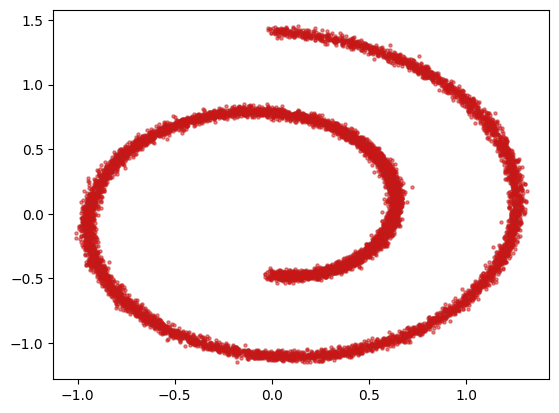

In [3]:
from sklearn.datasets import make_swiss_roll
num_samples = 10_000
dataset, _ = make_swiss_roll(num_samples, noise=0.2)
dataset = dataset[:, (0, 2)] / 10
plt.scatter(dataset[:, 0], dataset[:, 1], alpha=0.5, color='red', edgecolor='firebrick', s=5)
dataset = torch.Tensor(dataset).float()


In [4]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X):
        super().__init__()
        self.X = X

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index]


In [5]:
import torch.nn.functional as F

In [6]:
T = 250
β_all = 0.025**2 * torch.ones(T + 1)
α_all=1 - β_all
ᾱ_all = torch.cumsum(α_all.log(), dim=0).exp()
ᾱ_all[0] = 1


In [7]:
def compute_forward_process(x_0, t, device='cpu'):
    ε = torch.randn_like(x_0)
    ᾱ_t = ᾱ_all[t.to('cpu')].unsqueeze(-1).to(device)
    return ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t).sqrt() * ε, ε


In [8]:
def plot_evolution(x_all, is_reverse=False):
    fig, axes = plt.subplots(1, 11, figsize=(33, 3), sharex=True, sharey=True)
    for i in range(11):
        t = i * 25
        x_t = x_all[t]
        axes[i].scatter(x_t[:, 0], x_t[:, 1], color='grey', edgecolor='blue', s=5);
        axes[i].set_xticks([-1, 1])
        axes[i].set_yticks([-1, 1])
        label = T - t if is_reverse else t
        if label == T: label = 'T'
        axes[i].set_title(f't={label}')
        axes[i].axis('square')
    fig.tight_layout()


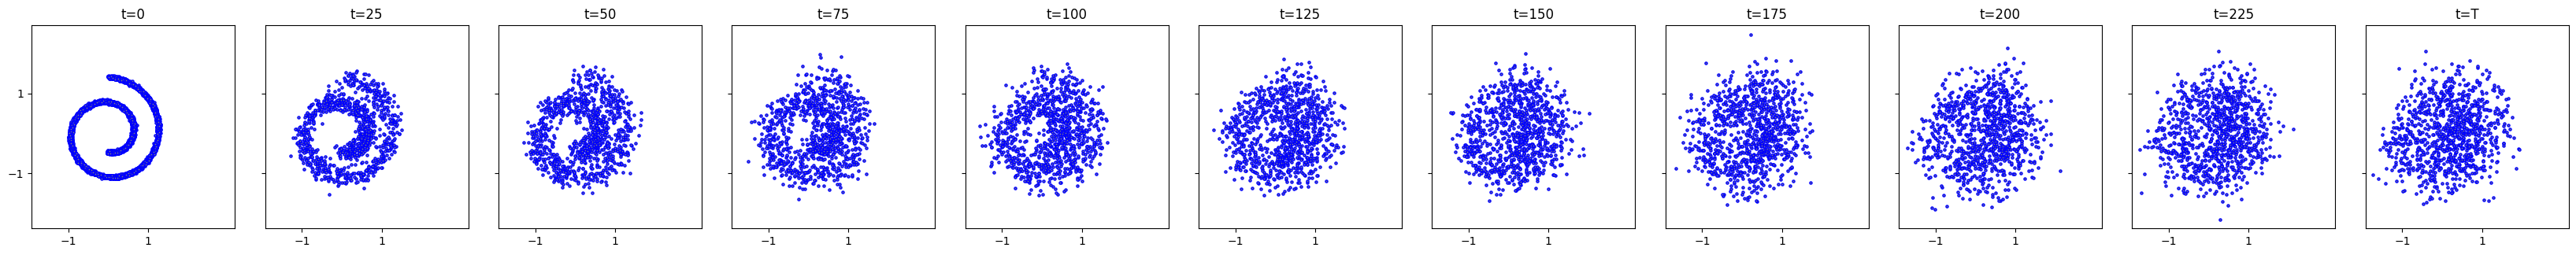

In [9]:
tmp = [compute_forward_process(dataset[:1_000], torch.as_tensor([t]))[0] if t != -1 else dataset for t in range(-1, T)]
plot_evolution(tmp)


In [10]:
def backward(x, t, pred_noise, z):
    if z is None:
        z = torch.randn_like(x)
    noise = β_all.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - α_all[t]) / (1 - ᾱ_all[t]).sqrt())) / α_all[t].sqrt()
    return mean + noise


In [11]:
@torch.no_grad()
def compute_reverse_process(model, num_samples, device='cpu'):
    retval = []
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(num_samples, 2).to(device)
    retval.append(samples.cpu())
    for t in range(T, 0, -1):
        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples).to(device) if t > 1 else 0
        x = torch.cat((samples, (t / T) * torch.ones((num_samples, 1)).to(device)), dim=1)
        eps = model(x)    # predict noise e_(x_t,t)
        samples = backward(samples, t, eps, z)
        retval.append(samples.cpu())
    return retval


In [12]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        # -- will not init when KAN
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [13]:
# Will use this later
# model = torch.nn.Sequential(
#     torch.nn.Linear(2 + 1, 32),
#     torch.nn.ReLU(),
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.Linear(32, 2)
# )


In [14]:
# Model, but itsaKUN!
model = torch.nn.Sequential(
    KAN([2 + 1, 32]),
    # torch.nn.Linear(2 + 1, 32); torch.nn.ReLU(),
    KAN([32, 32]),
    KAN([32, 32]),
    #torch.nn.Linear(32, 32); torch.nn.ReLU(),
    #torch.nn.ReLU(); torch.nn.Linear(32, 2)
    KAN([32, 2])
).to('cuda:0')

In [15]:
def compute_loss(model, x_0, t, device):
    #print(model.device)
    #print(x_0.device)
    #print(t.device)
    x_t, noise = compute_forward_process(x_0, t, device)
    xin = torch.cat((x_t, t.unsqueeze(-1) / T), dim=1)
    noise_pred = model(xin)
    return F.huber_loss(noise, noise_pred)


In [16]:
batch_size = 8192
data_loader = trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


Epoch 0: loss=0.42416200041770935 


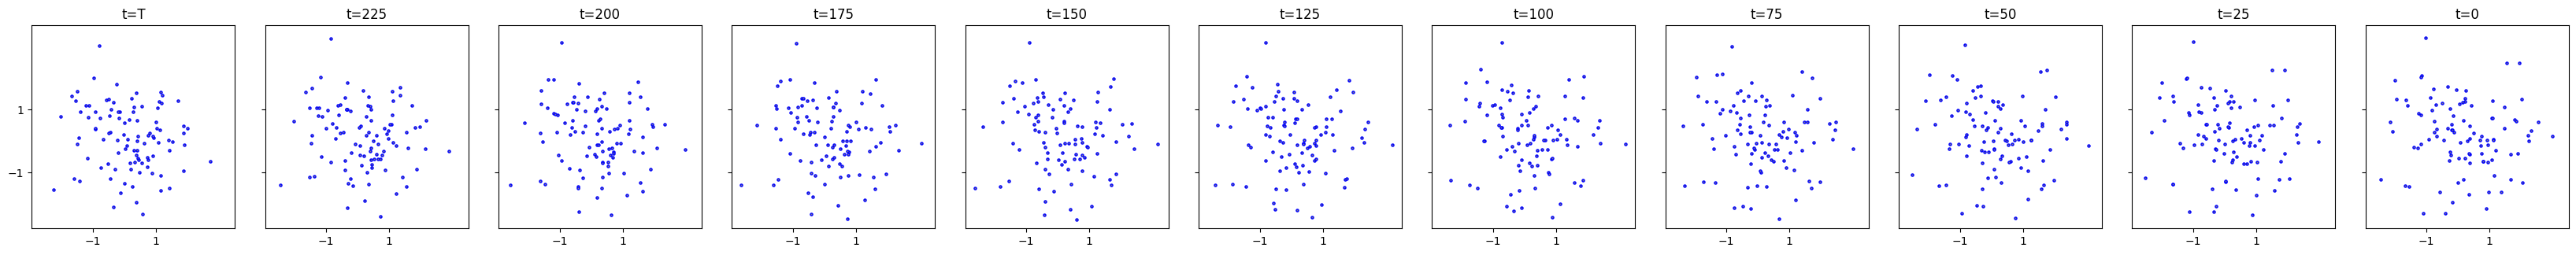

Epoch 1000: loss=0.27808642387390137 


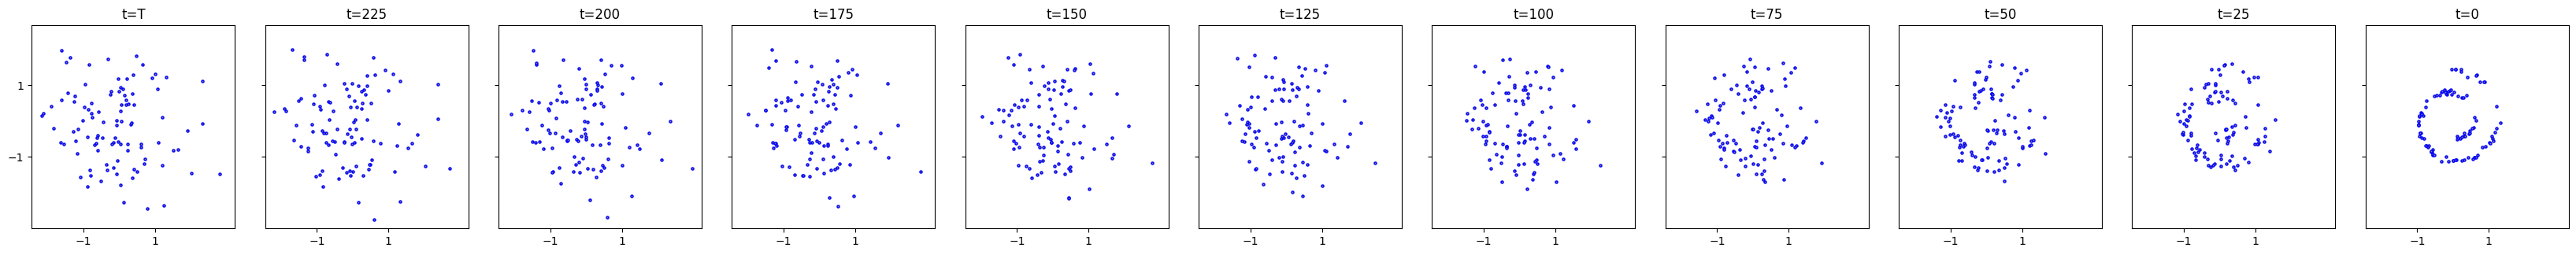

Epoch 2000: loss=0.29129502177238464 


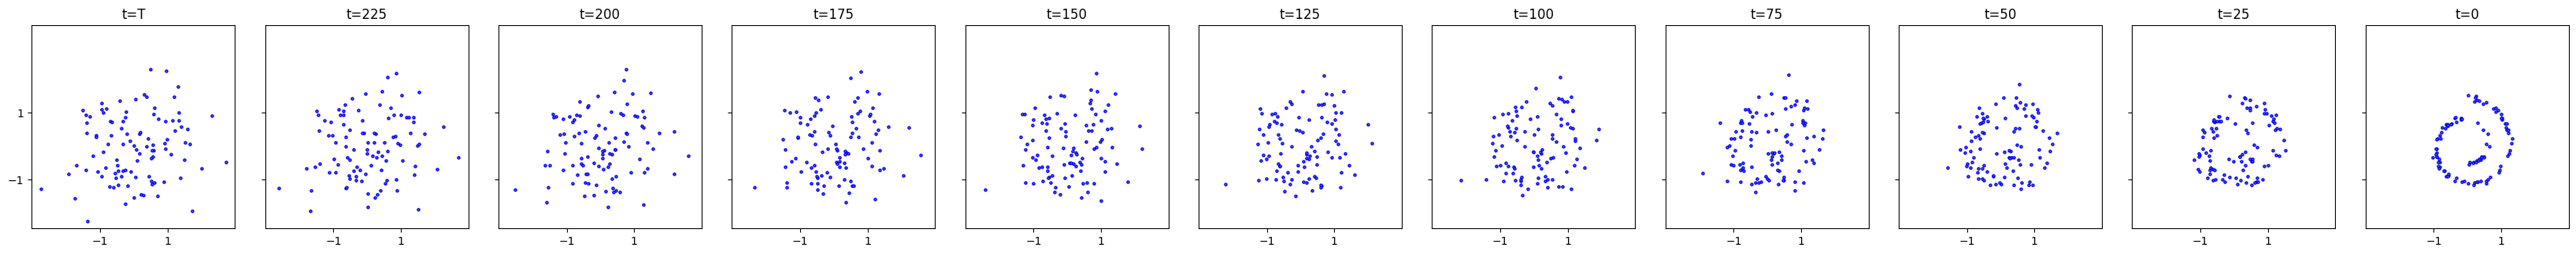

Epoch 3000: loss=0.28636959195137024 


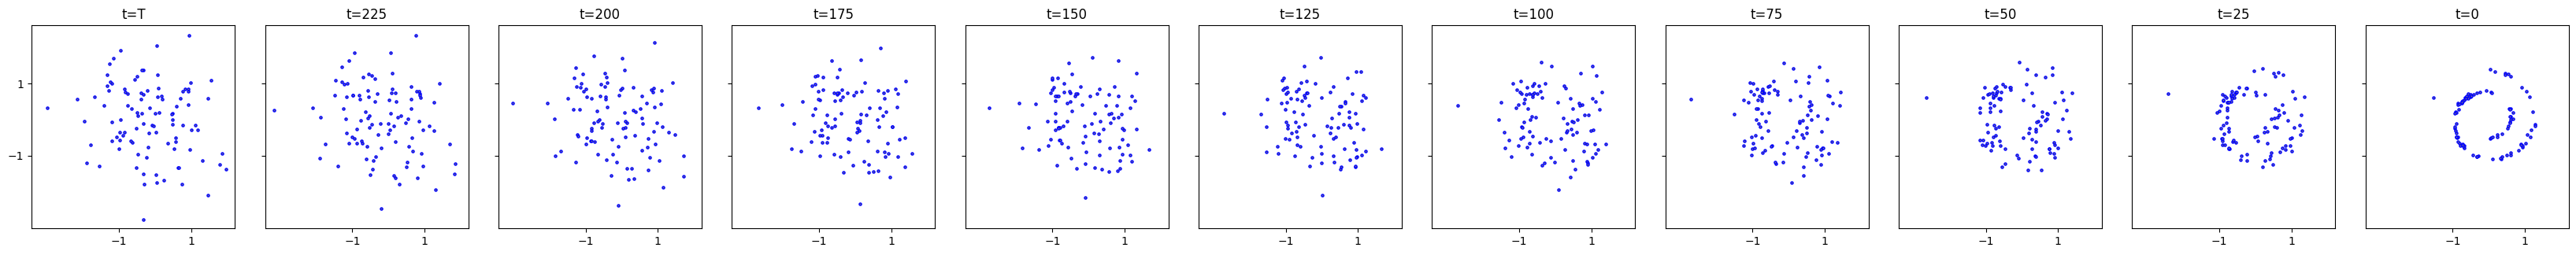

In [17]:
from torch.optim import Adam

model.apply(init_weights);

device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = Adam(model.parameters(), lr=0.002)
epochs = 4000

for epoch in range(epochs):
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()
      batch = batch.to(device)
      t = torch.randint(0, T, (batch.shape[0],), device=device).long()
      loss = compute_loss(model, batch, t, device)
      loss.backward()
      optimizer.step()

      if epoch % 1_000 == 0 and step == 0:
        print(f"Epoch {epoch}: loss={loss.item()} ")
        x_all = compute_reverse_process(model, 100, device)
        plot_evolution(x_all, True)
        plt.show()


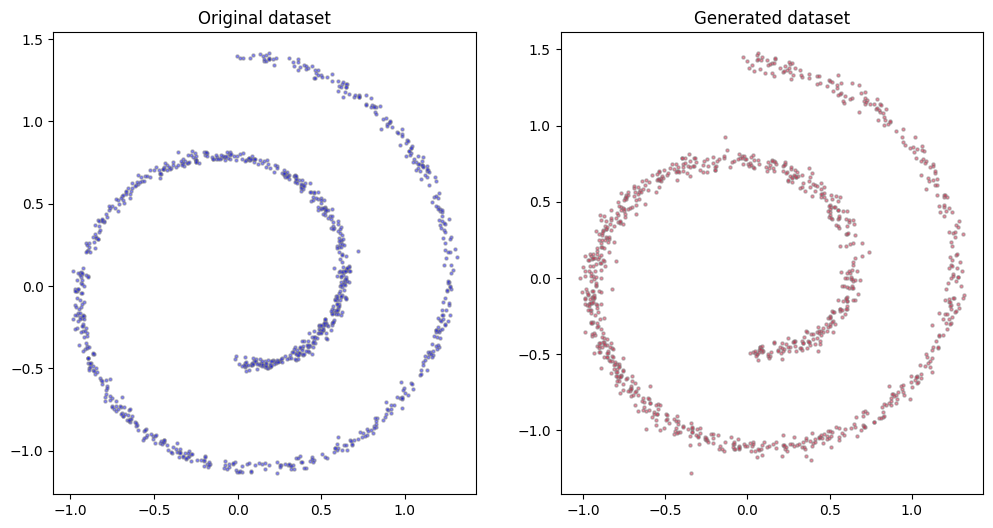

In [21]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), ncols=2)
n = 1_000
ax0.scatter(dataset[:n, 0], dataset[:n, 1], alpha=0.5, color='blue', edgecolor='grey', s=5)
ax0.set_title('Original dataset')
x_all = torch.stack(compute_reverse_process(model, n, device=device))
ax1.scatter(x_all[-1][:, 0], x_all[-1][:, 1], alpha=0.5, color='crimson', edgecolor='grey', s=5)
ax1.set_title('Generated dataset');


Not bad, not bad

OMG the network built to approximate continuous functions approximates continuous functions? 😱

KAN-generated anime girls by Greg Rutkowski when? 😡😡😡

Now let's compare it with MLP

In [22]:
model_vanilla = torch.nn.Sequential(
    torch.nn.Linear(2 + 1, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2)
).to(device)

Epoch 0: loss=0.4486212432384491 


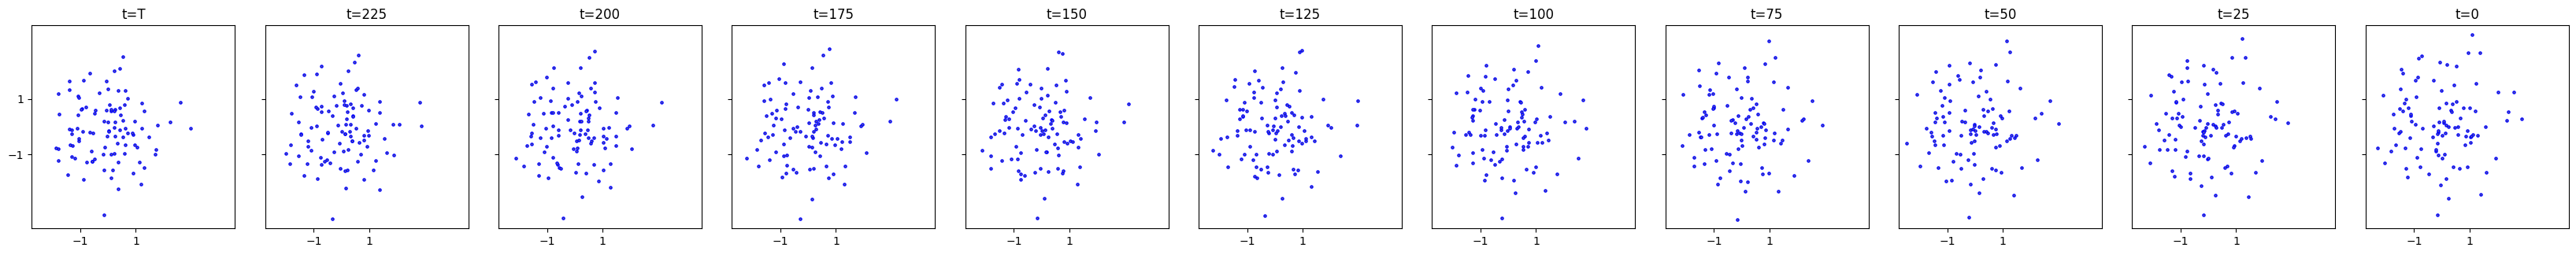

Epoch 1000: loss=0.2925262749195099 


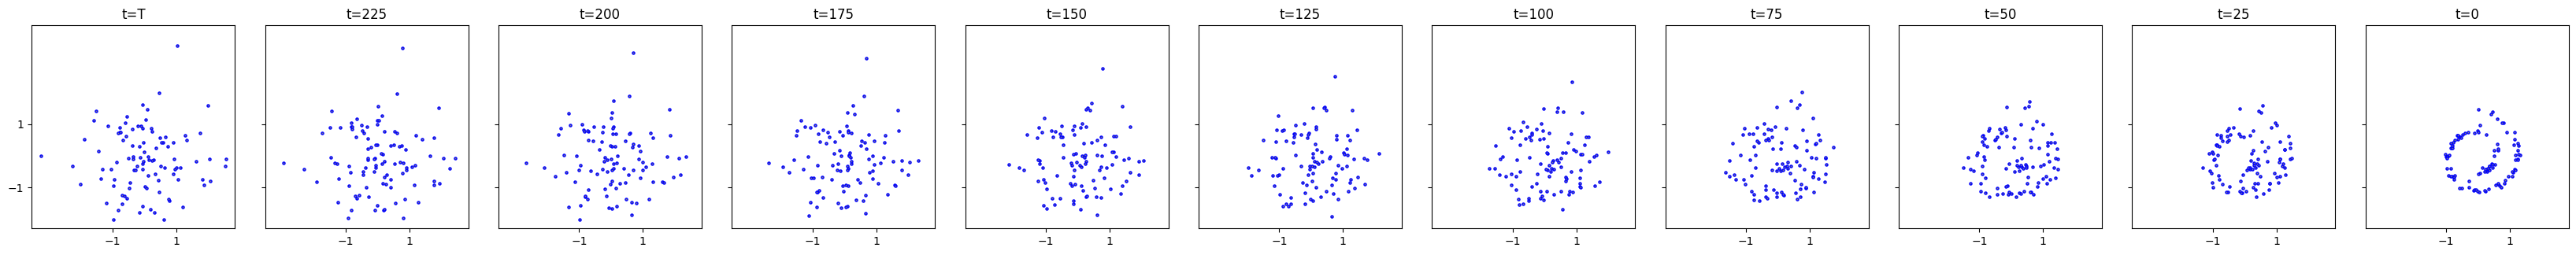

Epoch 2000: loss=0.2923603057861328 


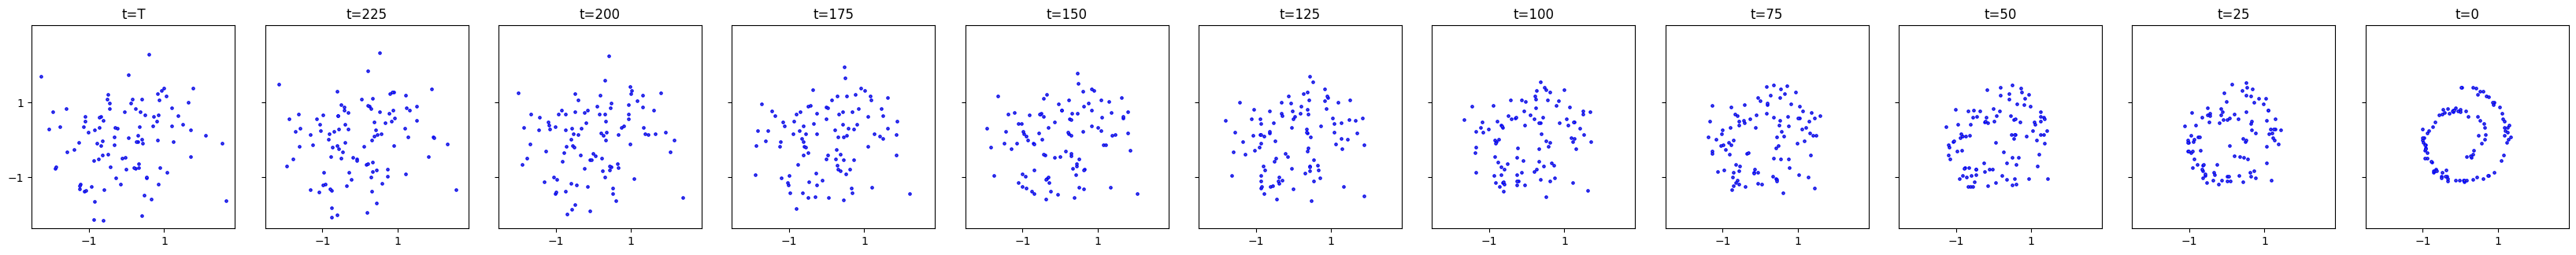

Epoch 3000: loss=0.2904841899871826 


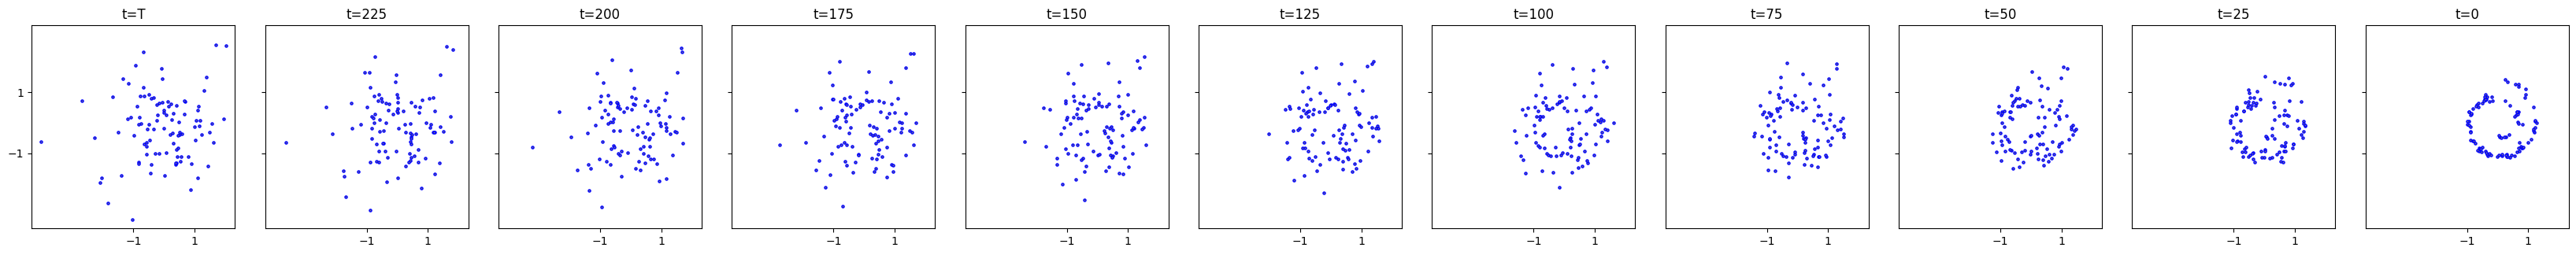

In [23]:
from torch.optim import Adam

model_vanilla.apply(init_weights);

device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = Adam(model_vanilla.parameters(), lr=0.002)
epochs = 4000

for epoch in range(epochs):
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()
      batch = batch.to(device)
      t = torch.randint(0, T, (batch.shape[0],), device=device).long()
      loss = compute_loss(model_vanilla, batch, t, device)
      loss.backward()
      optimizer.step()

      if epoch % 1_000 == 0 and step == 0:
        print(f"Epoch {epoch}: loss={loss.item()} ")
        x_all = compute_reverse_process(model_vanilla, 100, device)
        plot_evolution(x_all, True)
        plt.show()


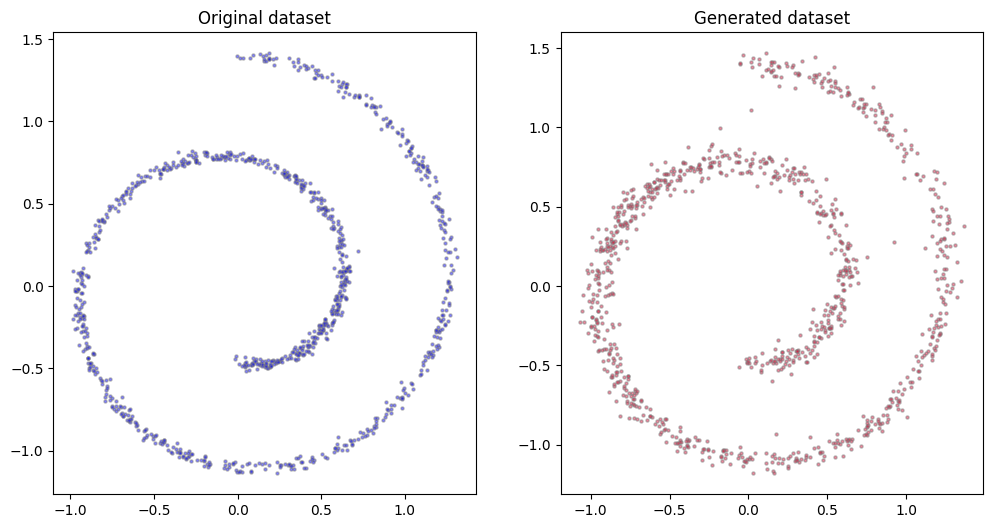

In [24]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), ncols=2)
n = 1_000
ax0.scatter(dataset[:n, 0], dataset[:n, 1], alpha=0.5, color='blue', edgecolor='grey', s=5)
ax0.set_title('Original dataset')
x_all = torch.stack(compute_reverse_process(model_vanilla, n, device=device))
ax1.scatter(x_all[-1][:, 0], x_all[-1][:, 1], alpha=0.5, color='crimson', edgecolor='grey', s=5)
ax1.set_title('Generated dataset');


Judging by the loss:


and that the generated examples look 'tighter' in KAN's case it can be said that the resulting KAN-model fared better. But what about the params?

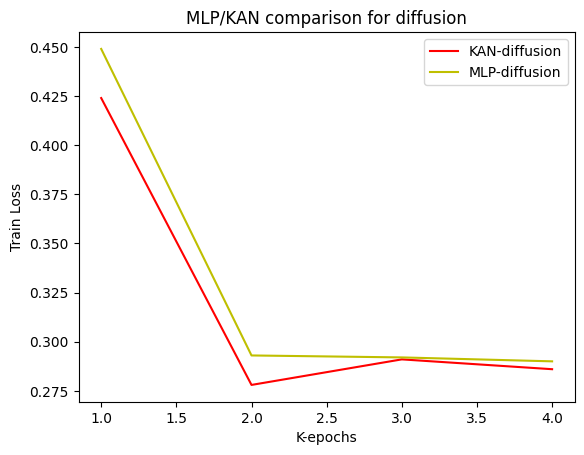

In [27]:
x = [1,2,3,4]
y_kan = [0.424, 0.278, 0.291, 0.286]
y_mlp = [0.449, 0.293, 0.292, 0.290]

import matplotlib.pyplot as plt 
plt.plot(x, y_kan, color = 'r', label = "KAN-diffusion")
plt.plot(x, y_mlp, color = 'y', label = "MLP-diffusion")
plt.xlabel('K-epochs') 
plt.ylabel('Train Loss') 
plt.title('MLP/KAN comparison for diffusion') 
plt.legend()
plt.show()

In [25]:
# KAN:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

22080

In [26]:
# Vanilla MLP:
pytorch_total_params = sum(p.numel() for p in model_vanilla.parameters() if p.requires_grad)
pytorch_total_params

2306

In [28]:
# Model, but itsaKUN! (smol, just two layer)
model_little = torch.nn.Sequential(
    KAN([2 + 1, 32]),
    # torch.nn.Linear(2 + 1, 32); torch.nn.ReLU(),
    #torch.nn.Linear(32, 32); torch.nn.ReLU(),
    #torch.nn.ReLU(); torch.nn.Linear(32, 2)
    KAN([32, 2])
).to('cuda:0')

In [29]:
# Vanilla MLP:
pytorch_total_params = sum(p.numel() for p in model_little.parameters() if p.requires_grad)
pytorch_total_params

1600

Epoch 0: loss=0.440459668636322 


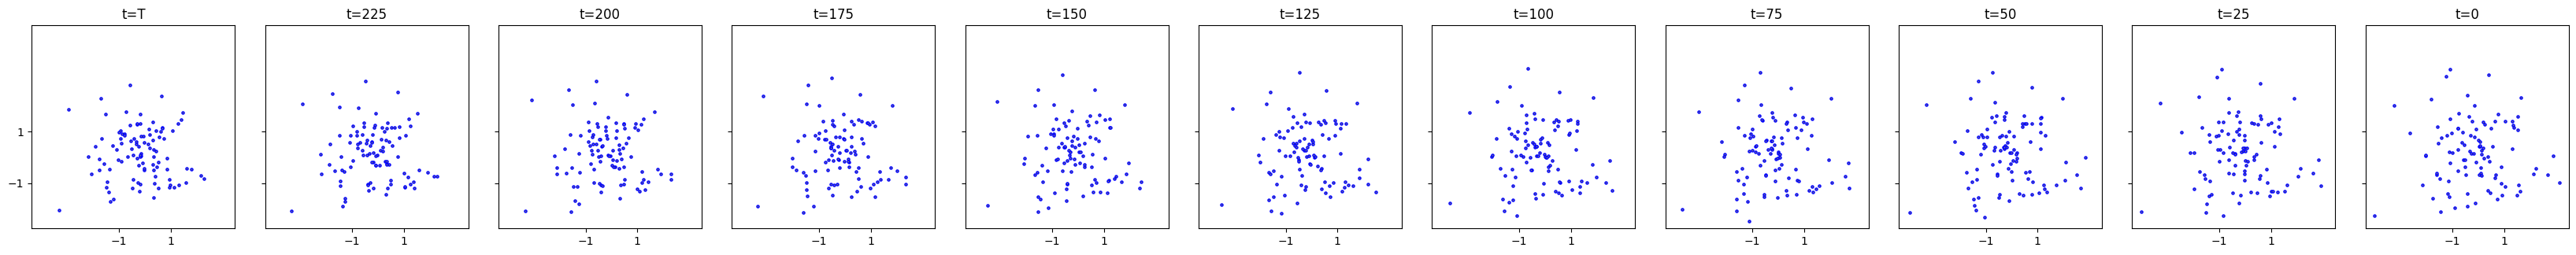

Epoch 1000: loss=0.2942555546760559 


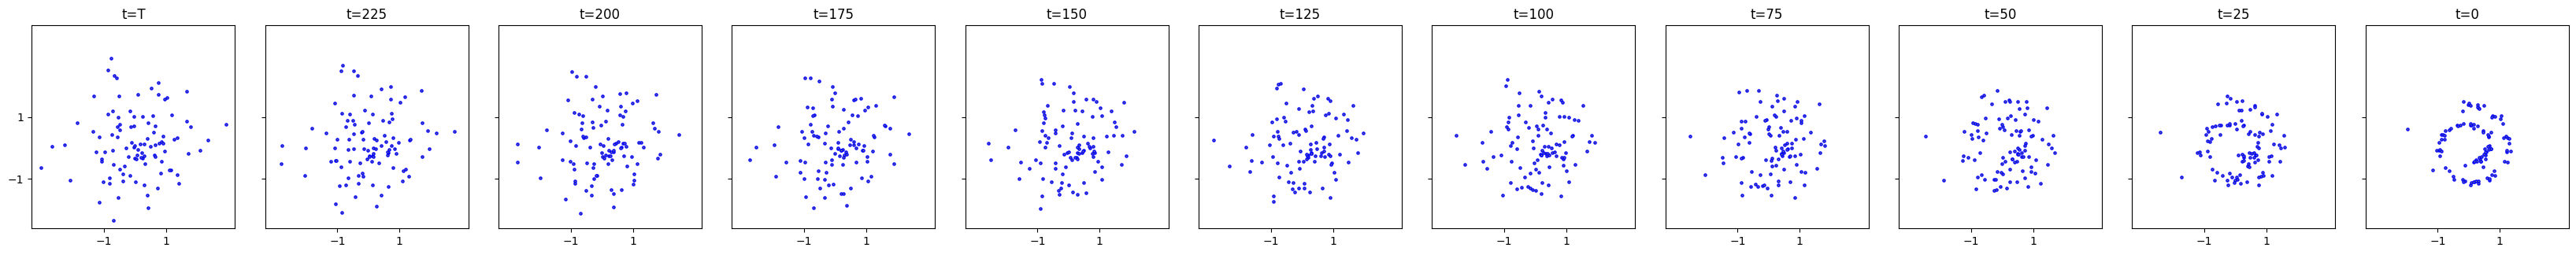

Epoch 2000: loss=0.29298678040504456 


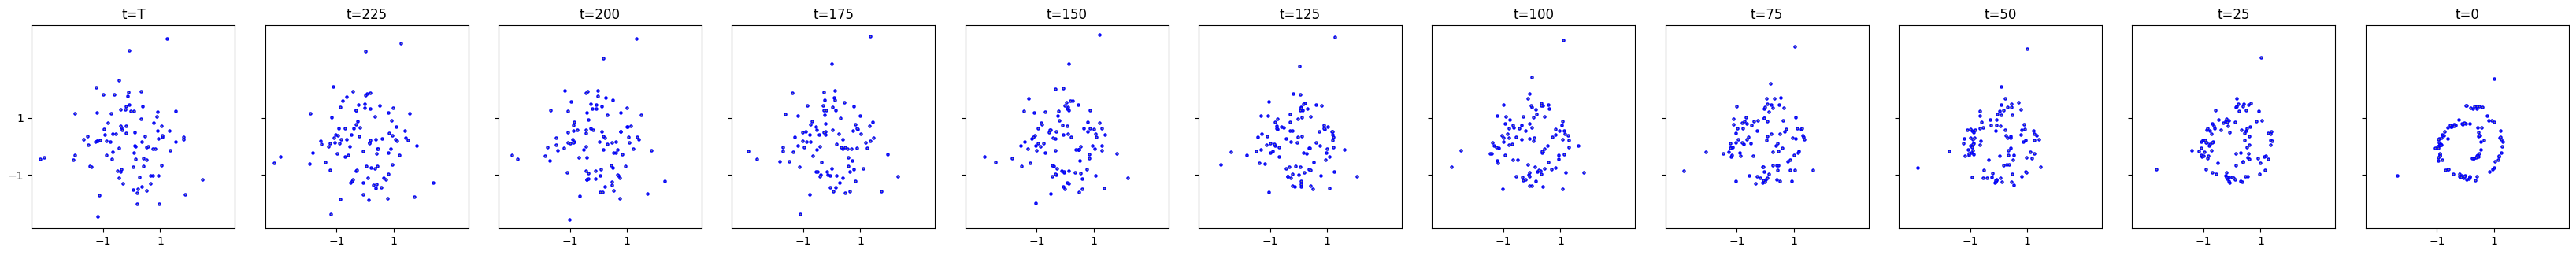

Epoch 3000: loss=0.29394668340682983 


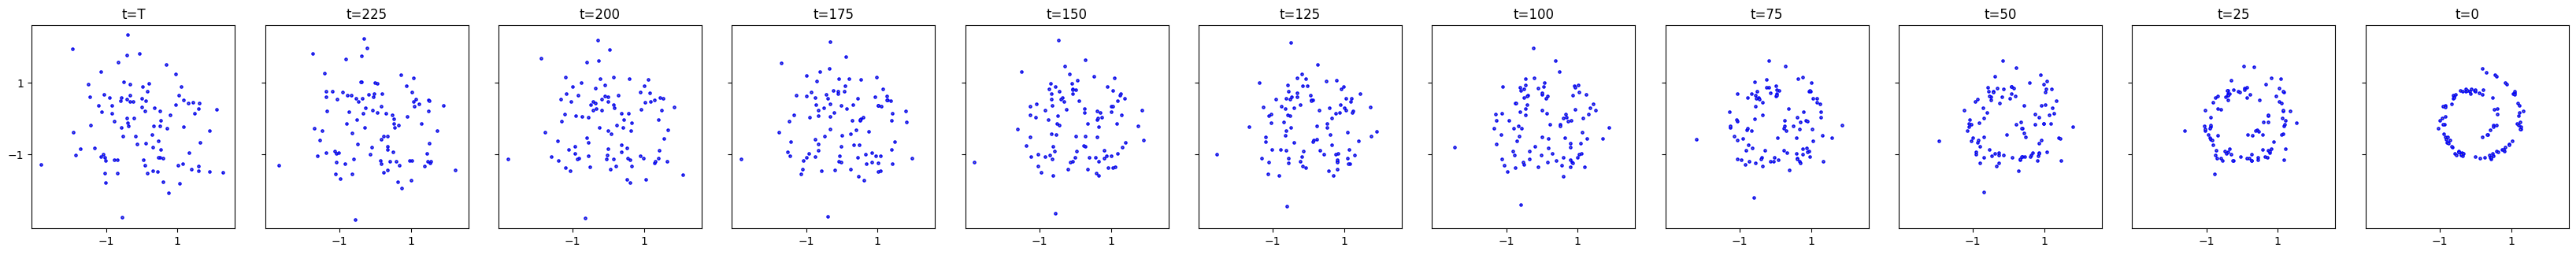

In [30]:
from torch.optim import Adam

model_little.apply(init_weights);

device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = Adam(model_little.parameters(), lr=0.002)
epochs = 4000

for epoch in range(epochs):
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()
      batch = batch.to(device)
      t = torch.randint(0, T, (batch.shape[0],), device=device).long()
      loss = compute_loss(model_little, batch, t, device)
      loss.backward()
      optimizer.step()

      if epoch % 1_000 == 0 and step == 0:
        print(f"Epoch {epoch}: loss={loss.item()} ")
        x_all = compute_reverse_process(model_little, 100, device)
        plot_evolution(x_all, True)
        plt.show()


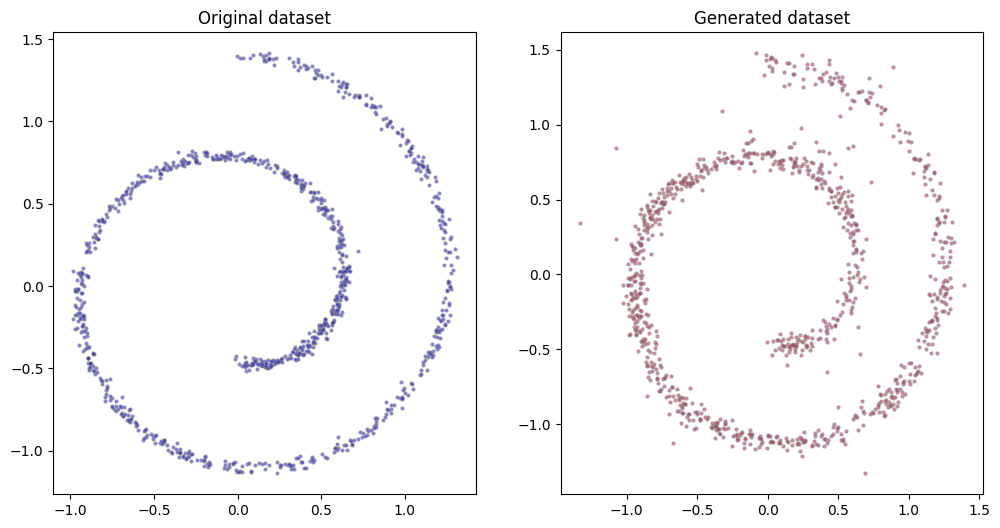

In [40]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), ncols=2)
n = 1_000
ax0.scatter(dataset[:n, 0], dataset[:n, 1], alpha=0.5, color='blue', edgecolor='grey', s=5)
ax0.set_title('Original dataset')
x_all = torch.stack(compute_reverse_process(model_little, n, device=device))
ax1.scatter(x_all[-1][:, 0], x_all[-1][:, 1], alpha=0.5, color='crimson', edgecolor='grey', s=5)
ax1.set_title('Generated dataset');


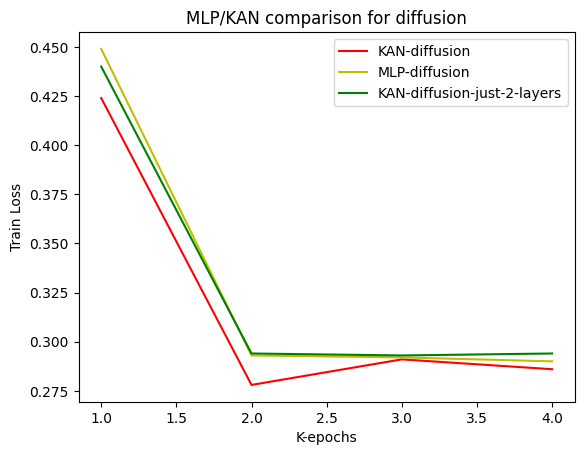

In [43]:
x = [1,2,3,4]
y_kan = [0.424, 0.278, 0.291, 0.286]
y_mlp = [0.449, 0.293, 0.292, 0.290]
y_kan_balanced = [0.440, 0.294, 0.293, 0.294]

import matplotlib.pyplot as plt 
plt.plot(x, y_kan, color = 'r', label = "KAN-diffusion")
plt.plot(x, y_mlp, color = 'y', label = "MLP-diffusion")
plt.plot(x, y_kan_balanced, color = 'g', label = "KAN-diffusion-just-2-layers")
plt.xlabel('K-epochs') 
plt.ylabel('Train Loss') 
plt.title('MLP/KAN comparison for diffusion') 
plt.legend()
plt.show()

Okay, we can see that KAN can be applied to denoising diffusion probibalistic modelling as well as the conventional networks.